In [484]:
import torch
import pickle
import timm 
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [485]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [486]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

In [487]:
print(x_train.shape)
print(x_train.device)

torch.Size([40000, 3, 32, 32])
mps:0


In [488]:
class ConvNet(nn.Module):
    def __init__(self, num_channels: int, num_classes: int, filters: list[int], activation: nn.Module = nn.ReLU):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                nn.Conv2d(filters[i], filters[i+1], kernel_size=3, stride=2, padding=1), 
                nn.BatchNorm2d(filters[i+1]),
                activation()
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv_layers(x)
        return self.flatten(h)


In [489]:
model = ConvNet(3, 10, [64, 128, 256, 512, 1024], nn.LeakyReLU).to(device)


In [490]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affin

In [491]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn):
    model.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    return sum(valid_loss) / len(valid_loss), sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, optim, loss_fn, train_loader, valid_loader, scheduler, epochs=10, batch_size=32, valid_every=1):
    
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        scheduler.step()
        if epoch % valid_every == 0:
            valid_loss, valid_acc = validate_model(model, valid_loader, loss_fn)
            all_valid_loss.append(valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {valid_loss}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)


In [492]:
from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

Epoch 0, Train Loss: 1.534896408700943, Valid Loss: 1.3927969793542125, Acc: 0.49460864067077637
Epoch 1, Train Loss: 1.1162969915390015, Valid Loss: 0.9918967908182845, Acc: 0.6487619876861572
Epoch 2, Train Loss: 0.9011294771671295, Valid Loss: 0.9236445835413644, Acc: 0.6676318049430847
Epoch 3, Train Loss: 0.7363024822473526, Valid Loss: 0.8403297682730154, Acc: 0.709664523601532
Epoch 4, Train Loss: 0.57246241106987, Valid Loss: 0.8816504866932147, Acc: 0.709664523601532
Epoch 5, Train Loss: 0.4017917557179928, Valid Loss: 0.7989803975382552, Acc: 0.7463058829307556
Epoch 6, Train Loss: 0.2343055918291211, Valid Loss: 0.9501505227039416, Acc: 0.7356230020523071
Epoch 7, Train Loss: 0.10962387416511774, Valid Loss: 1.0600273950507466, Acc: 0.7461062073707581
Epoch 8, Train Loss: 0.04819248665431514, Valid Loss: 1.0687044653267905, Acc: 0.7562899589538574
Epoch 9, Train Loss: 0.026376978388801216, Valid Loss: 1.0680508270336035, Acc: 0.7591853141784668


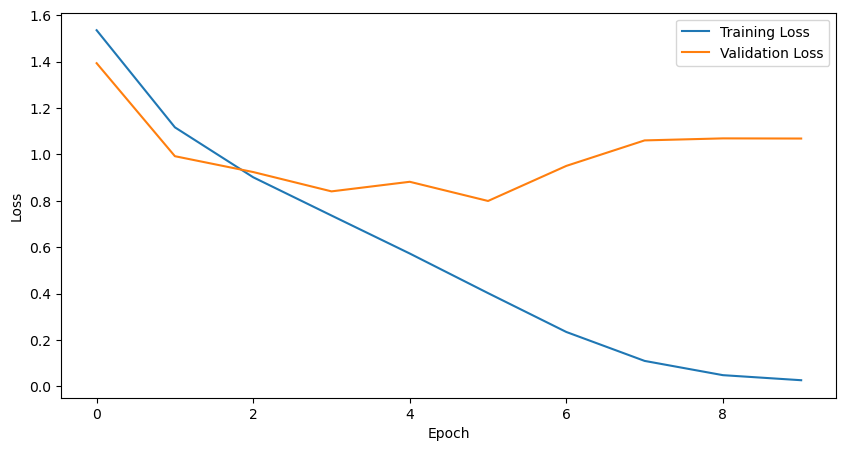

In [493]:
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
loss_fn = nn.CrossEntropyLoss()


train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=10, valid_every=1)

In [494]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation: nn.Module = nn.ReLU, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), 
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation: nn.Module = nn.ReLU, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, activation, kernel_size, stride, padding)
        self.idconv = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.activation = activation()

    def forward(self, x):
        h = self.conv1(x)
        h_id = self.idconv(x)
        return self.activation(h + h_id)


In [495]:
res_block = ResBlock(3, 64).to(device)
print(x_train[0].shape)
res_block(x_train[0].unsqueeze(0)).shape

torch.Size([3, 32, 32])


torch.Size([1, 64, 32, 32])

In [506]:
class ResNet(nn.Module):
    def __init__(self, num_channels: int, num_classes: int, filters: list[int], activation: nn.Module = nn.ReLU, stride: int = 2):
        super().__init__()
        res_layers = [
            ResBlock(num_channels, filters[0], activation, stride=1)
        ]
        for i in range(len(filters)-1):
            res_layers += [
                ResBlock(filters[i], filters[i+1], activation, stride=stride)
            ]
        self.res_layers = nn.Sequential(*res_layers)
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(filters[-1], num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
            activation()
        )

    def forward(self, x):
        for i, layer in enumerate(self.res_layers):
            x = layer(x)
        
        h = self.flatten(x)
        return self.linear(h)

In [522]:
model2 = ResNet(3, 10, [4, 8, 16, 32, 64, 128, 256], nn.ReLU, stride=2).to(device)
model2

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (1): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine

In [523]:
print(model.parameters())
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print(model2.parameters())
total_params = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters: {total_params}")



<generator object Module.parameters at 0x803c6c2e0>
Number of parameters: 6366730
<generator object Module.parameters at 0x803c6c2e0>
Number of parameters: 1229440


In [524]:
optim2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optim2, T_max=10)
loss_fn = nn.CrossEntropyLoss()
train_model(model2, optim2, loss_fn, train_dl, valid_dl, scheduler=scheduler2, epochs=10, valid_every=1)

Epoch 0, Train Loss: 1.67241498169899, Valid Loss: 1.4891453210157328, Acc: 0.4635583162307739
Epoch 1, Train Loss: 1.2836457225322724, Valid Loss: 1.225164543706388, Acc: 0.5661941170692444
Epoch 2, Train Loss: 1.1220051838874816, Valid Loss: 1.1130778602898692, Acc: 0.6147164702415466
Epoch 3, Train Loss: 1.016389432477951, Valid Loss: 1.0807124458181971, Acc: 0.6142172813415527
Epoch 4, Train Loss: 0.9252321276664733, Valid Loss: 0.9327532760441875, Acc: 0.6754193305969238
Epoch 5, Train Loss: 0.8379067987680435, Valid Loss: 0.9082962669694005, Acc: 0.6865016222000122
Epoch 6, Train Loss: 0.7588355212926865, Valid Loss: 0.8126989520205476, Acc: 0.7141573429107666
Epoch 7, Train Loss: 0.6787064866542816, Valid Loss: 0.7967867419932978, Acc: 0.7299321293830872
Epoch 8, Train Loss: 0.6071539987683297, Valid Loss: 0.7907986249596166, Acc: 0.7363218665122986
